# 连接仪器

In [100]:
%matplotlib notebook
from qulab.sugar import connect
from qulab.job import Job
from qulab.storage.utils import save
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np, sympy as sy, visa
from collections import namedtuple, deque, defaultdict, OrderedDict, Counter
from scipy.optimize import curve_fit, least_squares as ls
import time, asyncio, sys, imp, pandas as pd
from tqdm import tqdm_notebook as tqdm
from easydl import clear_output
from sklearn.cluster import KMeans
from scipy import signal
# from qulab import wavepoint
from qulab import optimize, measureroutine, computewave, imatrix, waveform_new
# from qulab.waveform import CosPulseDrag, Expi, DC, Step, Gaussian
from qulab.math.qst import transformList, acquireVFromData, vToRho
from qulab.math import opt
opt = imp.reload(opt)
op = imp.reload(optimize)
mr = imp.reload(measureroutine)
cw = imp.reload(computewave)
mx = imp.reload(imatrix)
wn = imp.reload(waveform_new)
# mn = imp.reload(measureroutine_new)
# wf = imp.reload(wavepoint)

In [101]:
pna = await connect('PNA')
dc01 = await connect('DC01')
dc02 = await connect('DC02')
dc03 = await connect('DC03')
dc04 = await connect('DC04')
dc05 = await connect('DC05')
dc06 = await connect('DC06')
dc07 = await connect('DC07')
dc08 = await connect('DC08')
dc10 = await connect('DC10')
dc11 = await connect('DC11')
dc15 = await connect('DC15')
dc20 = await connect('DC20')
psg_pump = await connect('PSG101')

# 中频及pump频率设置

In [110]:
f_medium, freq_center, dc_inst = 50e6, 6.74e9, dc15

In [77]:
dc = [dc01,dc02,dc03,dc04,dc05,dc06,dc07,dc08,dc10,dc11,dc15,dc20]
for i in dc:
    await i.setValue('Load','High')

# 设置网分

In [102]:
await pna.Output('ON')

E1026 20:48:03.159576  4836 base_events.py:1604] Exception in callback RPCMixin.cancelPending('tcp://10.122.7.19:64493', b'0K4\x17\x84...\x94\x8fm\xca', True)
handle: <TimerHandle when=182937.5 RPCMixin.cancelPending('tcp://10.122.7.19:64493', b'0K4\x17\x84...\x94\x8fm\xca', True)>
Traceback (most recent call last):
  File "C:\WPy64-3740\python-3.7.4.amd64\lib\site-packages\nest_asyncio.py", line 135, in run
    ctx.run(self._callback, *self._args)
  File "d:\qulab\qulab\rpc.py", line 106, in cancelPending
    fut.set_exception(QuLabRPCTimeout('Time out.'))
  File "C:\WPy64-3740\python-3.7.4.amd64\lib\asyncio\futures.py", line 246, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
asyncio.base_futures.InvalidStateError: CANCELLED: <Future cancelled>


In [95]:
# await pna.setValue('Number of points',1001)
# await pna.setValue('SweepType','Linear')   # Linear, CW
await pna.setValue('Power',0) 

# 单条Trace线

In [6]:
await pna.setValue('Frequency start',6.5e9)
await pna.setValue('Frequency stop',6.8e9)

In [73]:
await pna.setValue('Frequency center',6.588e9)
await pna.setValue('Frequency span',8e6)

<IPython.core.display.Javascript object>


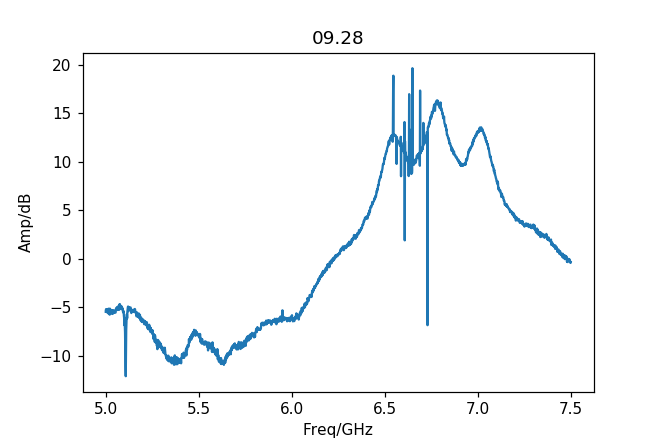

In [30]:
xaxis = await pna.get_Frequency(ch=1)
yaxis = await pna.get_S(ch=1,tr=1)
x, y = xaxis/1e9, 20*np.log10(np.abs(yaxis))
save('S21',tag,base_path=r'D:\skzhao\data\pna',row=xaxis,col=yaxis)
plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.xlabel('Freq/GHz')
plt.ylabel('Amp/dB')
plt.title('09.28')
# plt.legend(loc='lower right')
# plt.savefig(r'D:\skzhao\data\skzhao\\'+'100cm room temp cable'+'.jpg')
plt.show()

In [7]:
np.savez(r'D:\skzhao\data\skzhao\1to2 power spliter.npz',x=xaxis,y=yaxis)

In [19]:
await pna.getValue('trace')

<IPython.core.display.Javascript object>


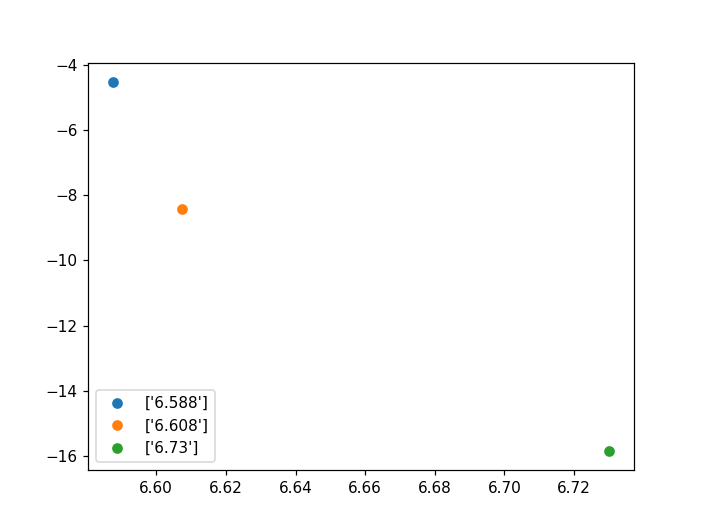

In [8]:
# y = op.RowToRipe().smooth(y,f0=0.8)
index, prominences = op.RowToRipe().findPeaks(y)
plt.figure(num='S21_Trace')
# plt.plot(x,z)
for j,i in enumerate(x[index]):
    plt.plot(i,y[index][j],'o',label=[f'{round(i,3)}'])
plt.legend(loc='lower left')

In [9]:
[round(i,3) for i in x[index]]

[6.588, 6.608, 6.73]

In [6]:
await dc_inst.DC(0)
await psg_pump.setValue('Output','OFF')

<IPython.core.display.Javascript object>


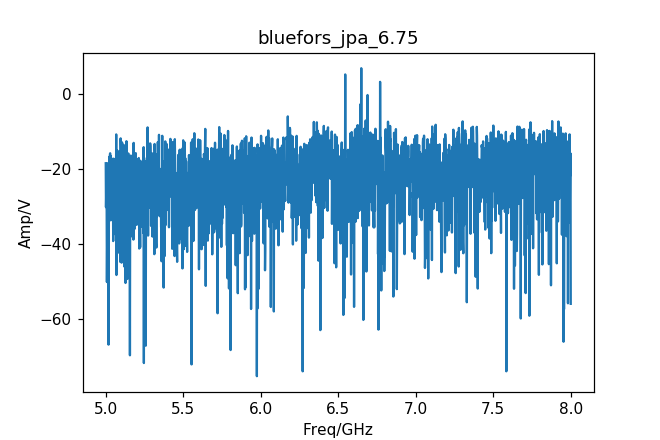

In [74]:
plt.figure(figsize=(6,4))
plt.plot(xaxis/1e9,20*np.log10(np.abs(y)),label='100cm ')
plt.xlabel('Freq/GHz')
plt.ylabel('Amp/V')
plt.title('bluefors_jpa_6.75')
# plt.legend(loc='lower right')
# plt.savefig(r'D:\skzhao\data\skzhao\\'+'100cm room temp cable'+'.jpg')
plt.show()

<IPython.core.display.Javascript object>


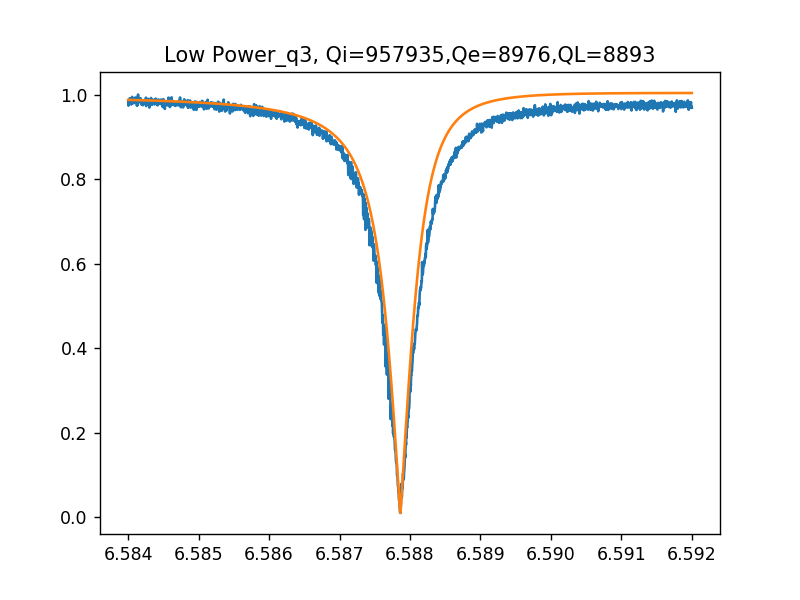

In [78]:
f, s21 = xaxis/1e9, yaxis
f0, Qi, Qe, QL, phi, f, s = op.Cavity_fit().fitCavity(f,s21)
plt.figure()
plt.plot(f,np.abs(s))
plt.title(f'Low Power_q3, Qi={int(Qi)},Qe={int(Qe)},QL={int(QL)}')
plt.plot(f,1/np.abs(op.Cavity_fit().invS21(f, f0, Qi, Qe, phi)))
plt.show()

In [24]:
np.savez('s21.npz',x=xaxis,y=yaxis)

# S21vsPower

In [11]:
async def S21vsPower(power):
    xaxis = await pna.get_Frequency(ch=1)
    for i in power:
        await pna.setValue('Power',i)
        yaxis = await pna.get_S(ch=1)
        yield [i], xaxis.reshape(len(xaxis),1), yaxis.reshape(len(yaxis),1)

In [12]:
power = np.linspace(-20,14,141)
tag = 'bluefors_10bits_zheng'
job = Job(S21vsPower, (power,), tags=[tag], max=len(power))
pp, fp, sp = await job.done()

Output()

# S21vsFlux_base

In [82]:
async def S21vsFlux_base(flux,dc_inst):
    xaxis = await pna.get_Frequency(ch=1)
    for i in flux:
        await dc_inst.DC(i)
        yaxis = await pna.get_S(ch=1)
        yield [i], xaxis.reshape(len(xaxis),1), yaxis.reshape(len(yaxis),1)

In [83]:
flux = np.linspace(-5,2,141)
# flux = np.linspace(-0.05,0.05,101) + ret.x[0]
# await pna.setValue('Frequency start',5e9)
tag = 'jpa'
# await psg_pump.setValue('Power',-1.98)
# await psg_pump.setValue('Output','OFF')
dc_inst = dc15
job = Job(S21vsFlux_base, (flux,dc_inst), tags=[tag], max=len(flux))
v, ff, base = await job.done()
await dc_inst.DC(0)

Output()

In [32]:
ff, base = op.RowToRipe().deductPhase(ff[0,:,0],base[0,:,0])

In [15]:
np.shape(base)

(1, 2001)

In [23]:
await dc_inst.DC(-0.5)

In [42]:
f_num = 854
index = np.argmax(np.abs(base[:,f_num,0]))
flux[index]

-0.874

# S21vsFlux

In [14]:
async def S21vsFlux(flux,dc_inst):
    xaxis = await pna.get_Frequency(ch=1)
    for j,i in enumerate(flux):
        await dc_inst.DC(i)
        yaxis = await pna.get_S(ch=1)
        yaxis /= base[j]
        yield [i], xaxis.reshape(len(xaxis),1), yaxis.reshape(len(yaxis),1)

In [17]:
# flux = np.linspace(-0.1,0.1,101) + (-2.218)
flux = np.linspace(-5,5,101)
# await pna.setValue('Frequency start',5e9)
tag = 'bluefors_jpa'
await psg_pump.setValue('Output','OFF')
job = Job(S21vsFlux, (flux,dc_inst), tags=[tag], max=len(flux))
v, ff, sf = await job.done()
await dc_inst.DC(0)

Output()

In [ ]:
f_num = 854
index = np.argmax(np.abs(sf[:,f_num,0]))
flux[index]

# BiasvsPumppower

In [84]:
async def SinglefreqBias(power):
    for i in power:
        await psg_pump.setValue('Power',i)
        yaxis = await pna.get_S(ch=1)
        yield [i], yaxis

In [85]:
async def BiasvsPump(flux,power,freq_center,dc_inst):
    await pna.setValue('Frequency center',freq_center)
    await pna.setValue('Frequency span',1)
    await pna.setValue('Number of points',1)  
    await psg_pump.setValue('Frequency',(2*freq_center+2e6))
#     xaxis = await pna.get_Frequency(ch=1)
    for j in flux:
        await dc_inst.DC(j)
        await psg_pump.setValue('Output','OFF')
        base = await pna.get_S(ch=1)
        await psg_pump.setValue('Output','ON')
        job = Job(SinglefreqBias, (power,), no_bar=True, auto_save=False, max=len(flux))
        v, sm = await job.done()
        sm /= base
        yield [j], v, sm

In [86]:
flux = np.linspace(-3.5,-1,51)
power = np.linspace(2,8,61)
# dc_inst = dc15
for i in [6.74e9,6.745e9,6.75e9,6.755e9,6.76e9]:
    freq_center = i
    tag = 'bluefors_jpa_xue'
    job = Job(BiasvsPump, (flux,power,freq_center,dc_inst), tags=[tag, f'fcenter={freq_center}'], max=len(power))
    v, ff, sf = await job.done()
    clear_output()
await dc_inst.DC(0)
await psg_pump.setValue('Output','OFF')

In [66]:
for i in [6.78e9,6.8e9]:
    freq_center = i
    tag = 'bluefors_jpa_xue'
    job = Job(BiasvsPump, (flux,power,freq_center,dc_inst), tags=[tag, f'fcenter={freq_center}'], max=len(power))
    v, ff, sf = await job.done()
    clear_output()
await dc_inst.DC(0)
await psg_pump.setValue('Output','OFF')

# 单纯形法

In [67]:
index = np.argwhere(np.abs(sf)==np.max(np.abs(sf)))[0]
p_op, c_op = power[index[1]], flux[index[0]]
print('current=%f, power=%f'%(c_op,p_op))

current=1.050000, power=3.000000


In [132]:
c_op=-1.25
p_op=4.7

In [121]:
await dc_inst.DC(c_op)
await psg_pump.setValue('Power',p_op)

In [133]:
async def Gain(bias,power):
    global f_cavity, dc_inst, psg_pump
    await dc_inst.DC(bias)
    await psg_pump.setValue('Power',power)
    s = []
    for i in f_cavity:
        await pna.setValue('Frequency center',i)
        sm = []
        for k in ['OFF','ON']:
            await psg_pump.setValue('Output',k)
            yaxis = await pna.get_S(ch=1)
            sm.append(yaxis)
        s.append(np.abs(sm[1]/sm[0])[0])
    return -20*np.log10(np.min(s))

In [134]:
f_cavity = np.array([6.545, 6.564, 6.588, 6.608, 6.63, 6.642, 6.649, 6.689, 6.71, 6.73])*1e9 + 2.5e6
freq_center = 6.755e9
await pna.setValue('Frequency span',1)
await pna.setValue('Number of points',1)  
await psg_pump.setValue('Frequency',(2*freq_center+2e6))
ret = opt.optimize(Gain,[c_op,p_op],[0.1,0.5],[3,2],print_info=True,algorithm='minimize')
print(ret.x)

.o
[-1.25  4.7 ] -0.06333881421882481   .o
[-1.15  4.7 ] -15.380517935921993   .......o
[-1.144  4.86 ] -15.541806434862107   ....o
[-1.166  4.81 ] -15.888714637904528   ...o
[-1.136  4.8  ] -15.970183366795052   ........o
[-1.138  4.79 ] -16.015217224467605   .....o
[-1.137  4.8  ] -16.06409589135088   ...................................
 CacheInfo(hits=28, misses=36, maxsize=128, currsize=36)
[-1.137  4.8  ]


In [135]:
await dc_inst.DC(ret.x[0])
# freq_center = 6.75e9
await psg_pump.setValue('Power',ret.x[1])
await psg_pump.setValue('Frequency',(2*freq_center+2e6))
await pna.setValue('Number of points',2001) 
await pna.setValue('Frequency start',5e9)
await pna.setValue('Frequency stop',7.5e9)
await psg_pump.setValue('Output','ON')

In [129]:
await psg_pump.setValue('Frequency',(2*freq_center+2e6))

In [50]:
await pna.setValue('Power',-12)

# S21vsPumppower

In [24]:
async def S21vsPump(power):
    await psg_pump.setValue('Output','ON')
    xaxis = await pna.get_Frequency(ch=1)
    for i in power:
        await psg_pump.setValue('Power',i)
#         await psg_pump.setValue('Output','ON')
        yaxis = await pna.get_S(ch=1)
        yield [i], xaxis.reshape(len(xaxis),1), yaxis.reshape(len(yaxis),1)

In [38]:
power = np.linspace(-2,2,81)+(3.79)
tag = 'bluefors_jpa_xue'
bias_op =1.8
await dc_inst.DC(bias_op)
job = Job(S21vsPump, (power,), tags=[tag, f'fcenter={freq_center}',f'bias={bias_op}'], max=len(power))
p, fs, ss = await job.done()

Output()

In [42]:
f_num = 854
# f_num = 1408
index = np.argmax(np.abs(ss[:,f_num,0]))
power[index]

3.89

In [43]:
3.59,3.89

(3.59, 3.89)

In [47]:
[-2.075,5.6]

[-2.075, 5.6]

In [49]:
await psg_pump.setValue('Power',3.59)
await dc_inst.DC(1.8)

In [45]:
await psg_pump.setValue('Output','ON')
# await dc_inst.DC(0)

# 饱和功率

In [115]:
async def SaturationPower(power,freq):
    await pna.setValue('Frequency center',freq)
    await pna.setValue('Frequency span',1)
    await pna.setValue('Number of points',1)  
    await psg_pump.setValue('Frequency',(2*freq_center+2e6))
    for i in power:
        await pna.setValue('Power',i)
        s = []
        for j in ['OFF','ON']:
            await psg_pump.setValue('Output',j)
            yaxis = await pna.get_S(ch=1)
            s.append(yaxis[0])
        yield [i], [s[1]/s[0]]

In [116]:
current_op = ret.x[0]
power_op = ret.x[1]
# current_op = 1.8
# power_op = 3.59
freq_read = 6.70895e9+2e6
freq_op = freq_read
power = np.linspace(-20,14,351)
await dc_inst.DC(current_op)
await psg_pump.setValue('Power',power_op)
await pna.setValue('Frequency',freq_read)
job = Job(SaturationPower, (power,freq_op), tags=[f'fcenter={freq_read}',f'bias={current_op}'], max=len(power))
ps, ss = await job.done()

Output()

<IPython.core.display.Javascript object>


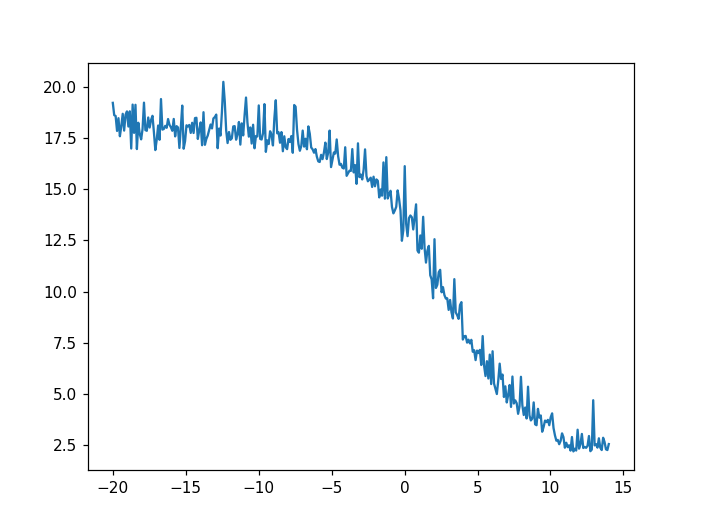

In [108]:
plt.figure()
plt.plot(ps,20*np.log10(abs(ss)))


In [60]:
6.7e9-6.8e9
6.75e9

6750000000.0

In [127]:
await dc_inst.DC(0)